<a href="https://colab.research.google.com/github/yasseriz/Super-Resolution/blob/master/SRGAN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install specific python package versions
!pip install scipy==1.0.0
!pip install numpy==1.17.4
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# Specify Colab to use Tensorflow 1x instead of 2x
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# Import libraries
import time
import keras
from keras import Input
from keras.layers import BatchNormalization, Activation, Add, LeakyReLU, Dense, MaxPooling2D
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.applications import VGG19
from keras.applications import ResNet50
from keras.callbacks import TensorBoard
from keras.models import Model
from keras.optimizers import Adam
import glob
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from scipy.misc import imresize, imread
from keras import backend as K
import math
import numpy
from skimage.measure import compare_ssim
import csv
import os.path

Using TensorFlow backend.


In [ ]:
def build_vgg():
    """
    Builds a pre-trained VGG19 model that outputs image features extracted at the
    third block of the model
    """
    input_shape = (256, 256, 3)
    vgg = VGG19(weights="imagenet")
    # Set the outputs to outputs of last conv. layer in block 3
    # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
    vgg.outputs = [vgg.layers[9].output]

    img = Input(shape=input_shape)

    # Extract the image features
    img_features = vgg(img)

    return Model(inputs=[img], outputs=[img_features], name='VGG')

In [ ]:
# Residual block for generator network
def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = PReLU()

    res = Conv2D(filters=filters[0], kernel_size=kernel_size,
                 strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size,
                 strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

In [ ]:
def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)
    counter = 0

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same')(input_layer)
    gen1 = Activation(PReLU())(gen1)
    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and
    #  the post-residual block(gen2)
    gen3 = Add(name='trial')([gen2, gen1])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    # gen4 = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation(PReLU())(gen4)

    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    # gen5 = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation(PReLU())(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same', activation='relu')(gen5)

    # Auto-Encoder
    l1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(gen6)
    l2 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)    
    l3 = MaxPooling2D(padding='same')(l2)

    l4 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
    l6 = MaxPooling2D(padding='same')(l5)

    l7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)
    # at this point the representation is (7, 7, 32)

    l8 = UpSampling2D()(l7)
    l9 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)
    
    l11 = Add(name='encode')([l10, l5])
    
    l12 = UpSampling2D((2, 2))(l11)

    l13 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)
    l15 = Add(name='decode')([l14, l2])
    decoded = Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)
    # Keras model
    model = Model(inputs=[input_layer], outputs=[decoded],
                  name='generator')

    return model

In [ ]:
# Discriminator Network
def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 3)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output_gen = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output_gen], name='discriminator')
    return model

In [ ]:
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):

    # Make a list of all images inside the data directory
    all_images = data_dir

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = imread(img, mode='RGB')
        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)

        # Do a random horizontal flip
        if np.random.random() < 0.5:
          img1_high_resolution = np.fliplr(img1_high_resolution)
          img1_low_resolution = np.fliplr(img1_low_resolution)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)

In [ ]:
def save_images(low_resolution_images, high_resolution_images, generated_images, path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_images[0])
    ax.axis("off")
    ax.set_title("Low Resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(high_resolution_images[0])
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_images[0])
    ax.axis("off")
    ax.set_title("Generated")

    plt.savefig(path)
    plt.clf()

In [ ]:
def PSNR(true_image, predicted_image):
    mse = numpy.mean((true_image - predicted_image) ** 2)
    Pixel_max = 1.0
    return 20 * math.log10(Pixel_max / math.sqrt(mse))

In [ ]:
filepath = '/content/gdrive/My Drive/Dataset/Saved_Weights/'
if __name__ == '__main__':
    # Define hyperparameters
    data_dir = glob('./Dataset/*')
    epochs = 10001
    batch_size = 2
    lr = 0.0002
    mode = 'train'
    # Shape of low-resolution and high-resolution images
    low_resolution_shape = (64, 64, 3)
    high_resolution_shape = (256, 256, 3)

    # Common optimizer for all networks
    common_optimizer = Adam(lr, 0.9)

    # Training the model
    if mode == 'train':

        # Building and compiling the networks
        vgg = build_vgg()
        vgg.trainable = False
        # print("VGG")
        # print(vgg.summary())
        vgg.compile(optimizer=common_optimizer, loss='mse', metrics=['accuracy'])

        discriminator = build_discriminator()
        # print("discrminator")
        # print(discriminator.summary())
        discriminator.load_weights("/content/gdrive/My Drive/Dataset/Saved_Weights/discriminator_imagenet1.hdf5")
        discriminator.compile(optimizer=common_optimizer, loss='mse', metrics=['accuracy'])
        print(discriminator.metrics_names)

        generator = build_generator()
        print("generator")
        print(generator.summary())

        # Building and compiling the adversarial network
        # High and Low resolution inputs to the network
        input_high_resolution = Input(shape=high_resolution_shape)
        input_low_resolution = Input(shape=low_resolution_shape)

        # Generating high resolution images from the generator
        generated_high_resolution_images = generator(input_low_resolution)

        # Extracting high resolution features using VGG network
        features = vgg(generated_high_resolution_images)

        # Discriminator model is turned off during adversarial training
        discriminator.trainable = False
        discriminator.load_weights("/content/gdrive/My Drive/Dataset/Saved_Weights/discriminator_imagenet1.hdf5")
        discriminator.compile(optimizer=common_optimizer, loss='mse', metrics=['accuracy'])

        # Probability of generated high resolution images
        probs = discriminator(generated_high_resolution_images)

        # Creating the adversarial model
        adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
        # print("Adversarial")
        # print(adversarial_model.summary())
        adversarial_model.load_weights("/content/gdrive/My Drive/Dataset/Saved_Weights/adversarial_model_imagenet1.hdf5")
        adversarial_model.compile(optimizer=common_optimizer, loss=['binary_crossentropy', 'mse'],
                                  loss_weights=[1e-3, 1])
        # print(adversarial_model.metrics_names)

        # Add Tensorboard
        # tensorboard = TensorBoard(log_dir="logs_imagenet_res/".format(time.time()))
        # tensorboard.set_model(generator)
        # tensorboard.set_model(discriminator)

        # Training
        for epoch in range(epochs):
            print("Epoch :{}".format(epoch))
            # experiment.log_parameter('epoch', epoch)

            # Training the discriminator network

            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          high_resolution_shape=high_resolution_shape,
                                                                          low_resolution_shape=low_resolution_shape)
            high_resolution_images = high_resolution_images / 255.0
            low_resolution_images = low_resolution_images / 255.0

            generated_high_resolution_images = generator.predict(low_resolution_images)

            # Generating batch of real and fake labels
            real_labels = np.ones((batch_size, 16, 16, 1))
            fake_labels = np.zeros((batch_size, 16, 16, 1))

            d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

            # write_log(tensorboard, 'd_loss_real', d_loss_real[0], epoch)
            # write_log(tensorboard, 'd_loss_real_acc', d_loss_real[1], epoch)
            # write_log(tensorboard, 'd_loss_fake', d_loss_fake[0], epoch)
            # write_log(tensorboard, 'd_loss_fake_acc', d_loss_fake[1], epoch)

            # Data logging to csv
            with open('/content/gdrive/My Drive/Dataset/LossAndAccuracy/d_loss_real.csv', 'a', newline='') as myfile:
                fileEmpty = os.stat('/content/gdrive/My Drive/Dataset/LossAndAccuracy/d_loss_real.csv').st_size == 0
            
                wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                headers = ['Loss', 'Acc']
                writer = csv.DictWriter(myfile, fieldnames=headers)
            
                if fileEmpty:
                    writer.writeheader()
            
                wr.writerow(d_loss_real)
            
            with open('/content/gdrive/My Drive/Dataset/LossAndAccuracy/d_loss_fake.csv', 'a', newline='') as myfile:
                fileEmpty = os.stat('/content/gdrive/My Drive/Dataset/LossAndAccuracy/d_loss_fake.csv').st_size == 0
            
                wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                headers = ['Loss', 'Acc']
                writer = csv.DictWriter(myfile, fieldnames=headers)
            
                if fileEmpty:
                    writer.writeheader()
            
                wr.writerow(d_loss_fake)

            # Calculating the discriminator loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print("d_loss :", d_loss)
            # print(type(d_loss))

            # Data logging to csv
            with open('/content/gdrive/My Drive/Dataset/LossAndAccuracy/d_loss.csv', 'a', newline='') as myfile:
                fileEmpty = os.stat('/content/gdrive/My Drive/Dataset/LossAndAccuracy/d_loss.csv').st_size == 0
                wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                headers = ['Loss', 'Acc']
                writer = csv.DictWriter(myfile, fieldnames=headers)
            
                if fileEmpty:
                    writer.writeheader()
                wr.writerow(d_loss)

            # Training the generator network
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          high_resolution_shape=high_resolution_shape,
                                                                          low_resolution_shape=low_resolution_shape)

            high_resolution_images = high_resolution_images / 255.0
            low_resolution_images = low_resolution_images / 255.0

            real_labels = np.ones((batch_size, 16, 16, 1))

            image_features = vgg.predict(high_resolution_images)

            g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                                      [real_labels, image_features])
            print("g_loss :", g_loss)
            # print(type(g_loss))

            # Data logging to csv
            with open('/content/gdrive/My Drive/Dataset/LossAndAccuracy/g_loss.csv', 'a', newline='') as myfile:
                fileEmpty = os.stat('/content/gdrive/My Drive/Dataset/LossAndAccuracy/g_loss.csv').st_size == 0
                wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                headers = ['Loss', 'Discriminator_loss', 'vgg_loss']
                writer = csv.DictWriter(myfile, fieldnames=headers)
            
                if fileEmpty:
                    writer.writeheader()
                wr.writerow(g_loss)

            # Write the losses to Tensorboard
            # write_log(tensorboard, 'g_loss', g_loss[0], epoch)
            # write_log(tensorboard, 'discriminator_loss', g_loss[1], epoch)
            # write_log(tensorboard, 'ResNet_loss', g_loss[2], epoch)

            # write_log(tensorboard, 'd_loss', d_loss[0], epoch)
            # write_log(tensorboard, 'd_acc', d_loss[1], epoch)

            # Saving images
            if epoch % 100 == 0:
                high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                              high_resolution_shape=high_resolution_shape,
                                                                              low_resolution_shape=low_resolution_shape)
                # Normalizing the images
                high_resolution_images = high_resolution_images / 255.0
                low_resolution_images = low_resolution_images / 255.0

                generated_images = generator.predict_on_batch(low_resolution_images)

                # low_resolution_images = 0.5 * low_resolution_images + 0.5
                # generated_images = 0.5 * generated_images + 0.5
                # high_resolution_images = 0.5 * high_resolution_images + 0.5

                for index, img in enumerate(generated_images):
                    save_images(low_resolution_images, high_resolution_images, generated_images,
                                path="/content/gdrive/My Drive/Dataset/Epoch_Images/img_{}".format(epoch))

                # Calculating PSNR and SSIM metrics
                psnr = PSNR(high_resolution_images[0], generated_images[0])
                print("PSNR: {}".format(psnr))
                psnr = [float(psnr)]
                # with open('PSNR', 'a', newline='') as myfileg:
                #     wr = csv.writer(myfileg, quoting=csv.QUOTE_ALL)
                #     wr.writerow(psnr)

                (score, diff) = compare_ssim(high_resolution_images[0], generated_images[0], full=True,
                                             multichannel=True)
                print("SSIM: {}".format(score))
                score = [float(score)]
                # with open('SSIM', 'a', newline='') as myfileg:
                #     wr = csv.writer(myfileg, quoting=csv.QUOTE_ALL)
                #     wr.writerow(score)

            adversarial_model.save_weights("/content/gdrive/My Drive/Dataset/Saved_Weights/adversarial_model_imagenet1.hdf5")
            discriminator.save_weights("/content/gdrive/My Drive/Dataset/Saved_Weights/discriminator_imagenet1.hdf5")
            generator.save_weights("/content/gdrive/My Drive/Dataset/Saved_Weights/generator_imagenet.hdf5")
            vgg.save_weights("/content/gdrive/My Drive/Dataset/Saved_Weights/vgg_imagenet.hdf5")
        # Predict Results
    if mode == 'Predict':
        # Build discriminator and generator
        discriminator = build_discriminator()
        generator = build_generator()

        # Load weights from training
        discriminator.load_weights("discriminator_imagenet_res.h5")
        generator.load_weights("generator_imagenet_res.h5")

        # Load test images
        data_dir = glob('./Predict/*')
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=2,
                                                                      high_resolution_shape=high_resolution_shape,
                                                                      low_resolution_shape=low_resolution_shape)
        # Normalizing the image
        high_resolution_images = high_resolution_images / 255.0
        low_resolution_images = low_resolution_images / 255.0

        generated_images = generator.predict_on_batch(low_resolution_images)

        # low_resolution_images = 0.5 * low_resolution_images + 0.5
        # generated_images = 0.5 * generated_images + 0.5
        # high_resolution_images = 0.5 * high_resolution_images + 0.5

        # Calculating PSNR and SSIM of images
        psnr1 = PSNR(high_resolution_images[0], generated_images[0])
        (score1, diff1) = compare_ssim(high_resolution_images[0], generated_images[0], full=True, multichannel=True)
        print("PSNR_first_image: {}".format(psnr1))
        print("SSIM_first_image: {}".format(score1))

        psnr2 = PSNR(high_resolution_images[1], generated_images[1])
        (score2, diff2) = compare_ssim(high_resolution_images[1], generated_images[1], full=True, multichannel=True)
        print("PSNR_second_image: {}".format(psnr2))
        print("SSIM_second_image: {}".format(score2))

        # Saving images
        for index, img in enumerate(generated_images):
            save_images(low_resolution_images, high_resolution_images, generated_images,
                        path="results/gen_{}".format(index))


In [ ]:
# Mount Google Drive folder to Colab
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
generator = build_generator()
generator.summary()

In [ ]:
# function to Visualise intermediate layers of a model
def visualize_conv_layer(layer_name):
  data_dir = glob('./Dataset/*')
  batch_size = 1
  low_resolution_shape=(64, 64, 3)
  high_resolution_shape=(256, 256, 3)
  high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                              high_resolution_shape=high_resolution_shape,
                                                                              low_resolution_shape=low_resolution_shape)
  high_resolution_images = high_resolution_images / 255.0
  low_resolution_images = low_resolution_images / 255.0

  layer_output=generator.get_layer(layer_name).output
#   layer_output=autoencoder.get_layer(layer_name).output

#   intermediate_model=Model(inputs=autoencoder.input,outputs=layer_output)
  intermediate_model=Model(inputs=generator.input,outputs=layer_output)

#   intermediate_prediction=intermediate_model.predict(high_resolution_images[0].reshape(1,256,256,3))
#   high_resolution_images = 0.5 * high_resolution_images + 0.5
  intermediate_prediction=intermediate_model.predict(low_resolution_images[0].reshape(1,64,64,3))
#   low_resolution_images = 0.5 * low_resolution_images + 0.5

  row_size=1
  col_size=3
  
  img_index=0

  print(np.shape(intermediate_prediction))
#   plt.figure
#   plt.imshow(intermediate_prediction[0][:][:][0])

#   fig,ax=plt.subplots(row_size,col_size)

#   for row in range(0,row_size):
#     for col in range(0,col_size):
#       ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='viridis')

#       img_index=img_index+1
  fig = plt.figure()
  ax = fig.add_subplot(1, 3, 1)
  ax.imshow(intermediate_prediction[0, :, :, 0], cmap='viridis')
  ax = fig.add_subplot(1, 3, 2)

  plt.imshow(intermediate_prediction[0, :, :, 1], cmap='viridis')
  ax = fig.add_subplot(1, 3, 3)

  plt.imshow(intermediate_prediction[0, :, :, 2], cmap='viridis')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1, 256, 256, 3)


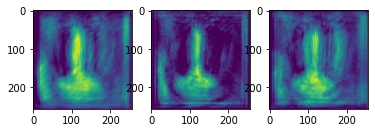

In [ ]:
visualize_conv_layer('conv2d_505')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1, 256, 256, 3)


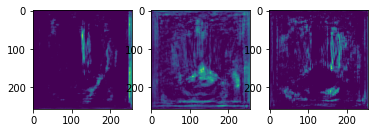

In [ ]:
visualize_conv_layer('conv2d_515')